# Soil Data Collection

In [32]:
data_folder = "../../data/raw/"
data_files = { 
    "fire_dz": "viirs-jpss1_2024_Algeria.csv",
    "fire_tn": "viirs-jpss1_2024_Tunisia.csv",
    "landcover_dz": "landcover_dz/dza_gc_adg.shp",
    "landcover_tn": "landcover_tn/tun_gc_adg.shp", 
    "climate_prec": "wc2.1_cruts4.09_5m_prec_2020-2024",
    "climate_tmax": "wc2.1_cruts4.09_5m_tmax_2020-2024",
    "climate_tmin": "wc2.1_cruts4.09_5m_tmin_2020-2024",
    "elevation": "be15_grd/be15_grd",
    "dz_boundaries": "gadm41_DZA_shp/gadm41_DZA_0.shp",
    "tn_boundaries": "gadm41_TUN_shp/gadm41_TUN_0.shp",
    "soil_bil": "HWSD2_RASTER/HWSD2.bil",
    "soil_csv": "HWSD2_DB/HWSD2_LAYERS.csv"
}

output_folder = "../../data/processed"
output_folders = {
    "fire": "fire",
    "landcover": "landcover",
    "climate": "climate",
    "elevation": "elevation",
    "soil": "soil"
}

In [33]:
import pandas as pd
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import geopandas
from rasterio.enums import Resampling
import numpy as np

## Helper Functions: Clip TN and DZ Data

In [34]:
### Loading and merging the boundaries of Algeria and Tunisia
def load_dz_tn_boundaries(dz_shapefile_path, tn_shapefile_path):
    dz = geopandas.read_file(dz_shapefile_path)
    tn = geopandas.read_file(tn_shapefile_path)

    # Ensure both shapefiles use the same CRS 
    if dz.crs != tn.crs:
        tn = tn.to_crs(dz.crs)

    # Concatenate the GeoDataFrames
    boundaries = geopandas.GeoDataFrame(pd.concat([dz, tn], ignore_index=True), crs=dz.crs)

    return boundaries

# Shapefile downloaded from https://gadm.org/
dz_boundaries_filepath = os.path.join(data_folder, data_files["dz_boundaries"])
tn_boundaries_filepath = os.path.join(data_folder, data_files["tn_boundaries"])

boundaries = load_dz_tn_boundaries(dz_boundaries_filepath, tn_boundaries_filepath)


def clip_instance(file, boundaries=boundaries):
    with rasterio.open(file) as src:
        # Clip raster with shapefile
        out_image, out_transform = mask(src, boundaries.geometry, crop=True)
        out_meta = src.meta.copy()
    
    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    return out_image, out_meta

## Preliminary Step: Display Data

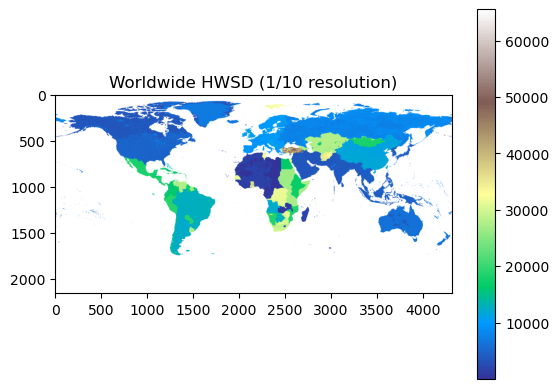

In [35]:
soil_filepath = os.path.join(data_folder, data_files["soil_bil"])

with rasterio.open(soil_filepath) as src:
    data = src.read(
        1,
        out_shape=(
            1,
            int(src.height / 10),  # reduce resolution by factor of 10
            int(src.width / 10)
        ),
        resampling=Resampling.bilinear
    )

plt.imshow(data, cmap='terrain')
plt.title("Worldwide HWSD (1/10 resolution)")
plt.colorbar()
plt.show()

# By: Narimane

## Loading and Clipping Data

In [36]:
with rasterio.open(soil_filepath) as src:
    print(src.driver)    
    print(src.width, src.height, src.shape)
    print(src.crs)
    print(src.bounds)
    arr = src.read(1) 
    print(arr.shape)

EHdr
43200 21600 (21600, 43200)
OGC:CRS84
BoundingBox(left=-179.99999999999966, bottom=-89.99999999999996, right=180.00000000000017, top=89.99999999999996)
(21600, 43200)


In [37]:
img, meta = clip_instance(soil_filepath)
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 2480,
 'height': 2233,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'),
 'transform': Affine(0.00833333333333333, 0.0, -8.674999999999727,
        0.0, -0.00833333333333333, 37.56666666666665)}

In [38]:
print(img)

[[[65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  ...
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]]]


Each pixel contains a `Soil Mapping Unit (SMU) ID`, that can be leveraged to map the data to the database.

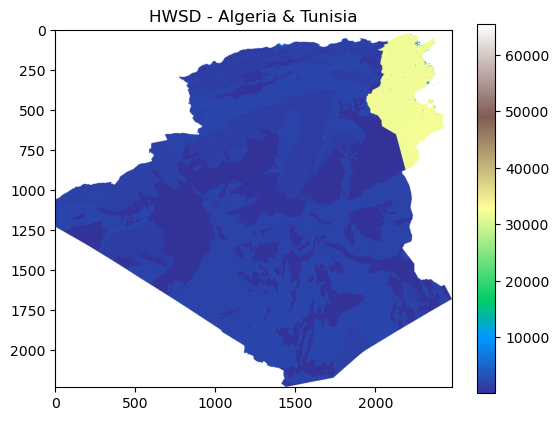

In [45]:
plt.imshow(img[0], cmap='terrain')
plt.title("HWSD - Algeria & Tunisia")
plt.colorbar()
plt.show()

## Saving the Raster to a `netCDF4` File

In [50]:
from typing import Dict, Any
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import json
import os

def _coords_from_meta(meta: Dict[str, Any]):
    """
    Build 1D x and y coordinates (pixel centers) from rasterio meta['transform'] and raster shape.
    Returns (y_coords, x_coords) as 1D numpy arrays.
    """
    transform = meta["transform"]
    # raster dims
    if "height" in meta and "width" in meta:
        h = int(meta["height"])
        w = int(meta["width"])
    else:
        raise ValueError("meta must contain integer 'height' and 'width' keys")

    # use rasterio.transform.xy in list comprehensions to get pixel center coords
    x_coords = np.array([rasterio.transform.xy(transform, 0, c, offset="center")[0] for c in range(w)])
    y_coords = np.array([rasterio.transform.xy(transform, r, 0, offset="center")[1] for r in range(h)])

    return y_coords, x_coords


def raster_to_netcdf(img: np.ndarray, meta: Dict[str, Any], out_path: str, var_name: str = "HWSD2_SMU_ID"):
    """
    Save a single-band raster array (img) to NetCDF.

    Parameters:
    - img: numpy array with shape (bands, height, width) or (height, width).
    - meta: rasterio meta dict including 'transform', 'height', 'width', 'crs'
    - out_path: output NetCDF file path
    - var_name: variable name to use inside NetCDF
    """
    # normalize img to 2D if needed
    if img.ndim == 3 and img.shape[0] == 1:
        arr = img[0]
    elif img.ndim == 2:
        arr = img
    else:
        # if multi-band, take first band by default
        arr = img[0]

    y_coords, x_coords = _coords_from_meta(meta)

    da = xr.DataArray(
        arr,
        dims=("y", "x"),
        coords={"y": y_coords, "x": x_coords},
        attrs={
            "crs": str(meta.get("crs", "")),
            "transform": json.dumps([float(v) for v in meta["transform"]]) if "transform" in meta else ""
        },
        name=var_name
    )

    ds = da.to_dataset()

    encoding = {var_name: {"zlib": True, "complevel": 4, "dtype": arr.dtype}}
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    ds.to_netcdf(out_path, engine="netcdf4", encoding=encoding)


In [52]:
output_base = os.path.join(output_folder, output_folders["soil"])
os.makedirs(output_base, exist_ok=True)
output_filepath = os.path.join(output_base, "smu_raster.nc")

raster_to_netcdf(img, meta, output_filepath)

## Reading the Database

Step1:
- `sudo apt install mdbtools`

Step2:
- `mdb-export HWSD2.mdb HWSD2_LAYERS > HWSD2_LAYERS.csv`

In [39]:
filepath = os.path.join(data_folder, data_files["soil_csv"])

layers_df = pd.read_csv(filepath)
layers_df.head()

/tmp/ipykernel_34244/3432650209.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  layers_df = pd.read_csv(filepath)


,ID,HWSD2_SMU_ID,NSC_MU_SOURCE1,NSC_MU_SOURCE2,WISE30s_SMU_ID,HWSD1_SMU_ID,COVERAGE,SEQUENCE,SHARE,NSC,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
0,1,1666,NaN,NaN,WD10001666,1666,4,1,70,NaN,...,8,50,4,5,71,0,4,0.0,2.9,1
1,2,6309,NaN,NaN,WD10006309,6309,4,1,50,NaN,...,8,50,4,5,71,0,4,0.0,2.9,1
2,3,1700,NaN,NaN,WD10001700,1700,4,1,60,NaN,...,8,50,4,5,71,0,4,0.0,2.9,1
3,4,6310,NaN,NaN,WD10006310,6310,4,1,30,NaN,...,8,50,4,5,71,0,4,0.0,2.9,1
4,5,6311,NaN,NaN,WD10006311,6311,4,1,50,NaN,...,8,50,4,5,71,0,4,0.0,2.9,1


In [40]:
layers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408835 entries, 0 to 408834
Data columns (total 48 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              408835 non-null  int64  
 1   HWSD2_SMU_ID    408835 non-null  int64  
 2   NSC_MU_SOURCE1  108878 non-null  object 
 3   NSC_MU_SOURCE2  108843 non-null  object 
 4   WISE30s_SMU_ID  408835 non-null  object 
 5   HWSD1_SMU_ID    408835 non-null  int64  
 6   COVERAGE        408835 non-null  int64  
 7   SEQUENCE        408835 non-null  int64  
 8   SHARE           408835 non-null  int64  
 9   NSC             0 non-null       float64
 10  WRB_PHASES      408825 non-null  object 
 11  WRB4            396594 non-null  object 
 12  WRB2            408835 non-null  object 
 13  FAO90           408835 non-null  object 
 14  ROOT_DEPTH      59917 non-null   float64
 15  PHASE1          112809 non-null  float64
 16  PHASE2          111029 non-null  float64
 17  ROOTS     

In [41]:
layers_df.isna().sum()

ID                     0
HWSD2_SMU_ID           0
NSC_MU_SOURCE1    299957
NSC_MU_SOURCE2    299992
WISE30s_SMU_ID         0
HWSD1_SMU_ID           0
COVERAGE               0
SEQUENCE               0
SHARE                  0
NSC               408835
WRB_PHASES            10
WRB4               12241
WRB2                   0
FAO90                  0
ROOT_DEPTH        348918
PHASE1            296026
PHASE2            297806
ROOTS             338394
IL                338394
SWR               235823
DRAINAGE           62973
AWC               350430
ADD_PROP            5236
LAYER                  0
TOPDEP                 0
BOTDEP                 0
COARSE                 0
SAND                   0
SILT                   0
CLAY                   0
TEXTURE_USDA       62584
TEXTURE_SOTER          0
BULK                   0
REF_BULK           62584
ORG_CARBON         23665
PH_WATER               0
TOTAL_N                0
CN_RATIO               0
CEC_SOIL               0
CEC_CLAY               0


#### Filtering by Layer

In [42]:
layers_df['LAYER'].value_counts()

LAYER
D2    58405
D3    58405
D4    58405
D5    58405
D6    58405
D7    58405
D1    58405
Name: count, dtype: int64

In [43]:
layers_df = layers_df[layers_df['LAYER'] == 'D1']
layers_df['LAYER'].nunique()

1

#### Extracting Features

In [46]:
features_oi = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND", "SHARE", "HWSD2_SMU_ID"
]

soil_df = layers_df[features_oi]

In [47]:
soil_df.head()

,COARSE,SAND,SILT,CLAY,TEXTURE_USDA,TEXTURE_SOTER,BULK,REF_BULK,ORG_CARBON,PH_WATER,...,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND,SHARE,HWSD2_SMU_ID
666,5,67,18,15,11.0,C,1.35,1.63,1.062,6.3,...,6,5,59,0,2,0.0,0.1,1,20,12704
667,5,67,18,15,11.0,C,1.35,1.63,1.062,6.3,...,6,5,59,0,2,0.0,0.1,1,20,12705
668,5,67,18,15,11.0,C,1.35,1.63,1.062,6.3,...,6,5,59,0,2,0.0,0.1,1,40,12707
669,5,67,18,15,11.0,C,1.35,1.63,1.062,6.3,...,6,5,59,0,2,0.0,0.1,1,20,12708
694,2,24,52,24,7.0,M,1.44,1.76,1.475,5.2,...,6,4,41,50,2,0.0,0.1,0,100,11825


## Saving Soil Attributes to a `csv` File

In [53]:
filepath = os.path.join(output_base, "soil.csv")
soil_df.to_csv(filepath, index=False)